In [0]:
display(dbutils.fs.ls("/FileStore/tables/"))

path,name,size,modificationTime
dbfs:/FileStore/tables/deliveries.csv,deliveries.csv,27019953,1740913317000
dbfs:/FileStore/tables/matches.csv,matches.csv,225266,1740913310000


In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('IPL Data Analysis').getOrCreate()

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType, DateType

In [0]:
from pyspark.sql.functions import col, when, sum, avg, asc, desc

In [0]:

deliveries_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("inning", IntegerType(), True),
    StructField("batting_team", StringType(), True),
    StructField("bowling_team", StringType(), True),
    StructField("over", IntegerType(), True),
    StructField("ball", IntegerType(), True),
    StructField("batter", StringType(), True),
    StructField("bowler", StringType(), True),
    StructField("non_striker", StringType(), True),
    StructField("batsman_runs", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("total_runs", IntegerType(), True),
    StructField("extras_type", StringType(), True),
    StructField("is_wicket", IntegerType(), True),
    StructField("player_dismissed", StringType(), True),
    StructField("dismissal_kind", StringType(), True),
    StructField("fielder", StringType(), True)
])

In [0]:
matches_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("season", StringType(), True),
    StructField("city", StringType(), True),
    StructField("date", DateType(), True),
    StructField("match_type", StringType(), True),
    StructField("player_of_match", StringType(), True),
    StructField("venue", StringType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("toss_decision", StringType(), True),
    StructField("winner", StringType(), True),
    StructField("result", StringType(), True),
    StructField("result_margin", IntegerType(), True),
    StructField("target_runs", IntegerType(), True),
    StructField("target_overs", IntegerType(), True),
    StructField("super_over", StringType(), True),
    StructField("method", StringType(), True),
    StructField("umpire1", StringType(), True),
    StructField("umpire2", StringType(), True)
])

In [0]:
matches = spark.read.schema(matches_schema).format("csv").option("header", "true").option("inferSchema", "true").load("matches.csv")
deliveries = spark.read.schema(deliveries_schema).format("csv").option("header", "true").load("deliveries.csv")

In [0]:
matches.show(5)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|method|  umpire1|       umpire2|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knig

In [0]:
matches.select("super_over").distinct().show()

+----------+
|super_over|
+----------+
|         Y|
|         N|
+----------+



In [0]:
matches = matches.withColumn("super_over", when(col("super_over") == "Y", True).when(col("super_over") == "N", False).cast(BooleanType()))

In [0]:
matches.select("super_over").distinct().show()

+----------+
|super_over|
+----------+
|      true|
|     false|
+----------+



In [0]:
deliveries = deliveries.withColumn("is_wicket", when(col("is_wicket") == 1, True).when(col("is_wicket") == 0, False).cast(BooleanType()))

In [0]:
deliveries.select(col("is_wicket")).distinct().show()

+---------+
|is_wicket|
+---------+
|     true|
|    false|
+---------+



In [0]:
deliveries.columns

Out[114]: ['match_id',
 'inning',
 'batting_team',
 'bowling_team',
 'over',
 'ball',
 'batter',
 'bowler',
 'non_striker',
 'batsman_runs',
 'extra_runs',
 'total_runs',
 'extras_type',
 'is_wicket',
 'player_dismissed',
 'dismissal_kind',
 'fielder']

In [0]:
matches.columns

Out[115]: ['id',
 'season',
 'city',
 'date',
 'match_type',
 'player_of_match',
 'venue',
 'team1',
 'team2',
 'toss_winner',
 'toss_decision',
 'winner',
 'result',
 'result_margin',
 'target_runs',
 'target_overs',
 'super_over',
 'method',
 'umpire1',
 'umpire2']

In [0]:
deliveries.select("extras_type").distinct().show()

+-----------+
|extras_type|
+-----------+
|       null|
|    noballs|
|    penalty|
|      wides|
|       byes|
|    legbyes|
+-----------+



In [0]:
not_normal_deliveries = deliveries.filter((col("extras_type") == "penalty") | (col("extras_type") == "noballs"))

In [0]:
not_normal_deliveries.select("extras_type").distinct().show()

+-----------+
|extras_type|
+-----------+
|    noballs|
|    penalty|
+-----------+



In [0]:
wide_deliveries = deliveries.filter(deliveries.extras_type == "wides")

In [0]:
wide_deliveries.select("extras_type").distinct().show()

+-----------+
|extras_type|
+-----------+
|      wides|
+-----------+



In [0]:
wide_deliveries.show(5)

+--------+------+--------------------+--------------------+----+----+-----------+---------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|match_id|inning|        batting_team|        bowling_team|over|ball|     batter|   bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|
+--------+------+--------------------+--------------------+----+----+-----------+---------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   3|BB McCullum|  P Kumar| SC Ganguly|           0|         1|         1|      wides|    false|              NA|            NA|     NA|
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   3|   1|BB McCullum|AA Noffke| SC Ganguly|           0|         5|         5|      wides|    false|              NA|            NA|    

In [0]:
total_n_avg_runs = deliveries.groupBy("match_id", "inning").agg(
    sum("total_runs").alias("total_ing_runs"),
    avg("total_runs").alias("avg_ing_runs")
)

In [0]:
total_n_avg_runs.show(5)

+--------+------+--------------+------------------+
|match_id|inning|total_ing_runs|      avg_ing_runs|
+--------+------+--------------+------------------+
|  336009|     1|           187|1.4841269841269842|
|  392196|     1|           165|1.2992125984251968|
|  419132|     1|           163|1.2834645669291338|
|  392196|     2|           169| 1.396694214876033|
|  335993|     1|           147|1.1666666666666667|
+--------+------+--------------+------------------+
only showing top 5 rows



In [0]:
total_n_avg_runs.sort(asc("match_id")).show(5)

+--------+------+--------------+------------------+
|match_id|inning|total_ing_runs|      avg_ing_runs|
+--------+------+--------------+------------------+
|  335982|     1|           222|1.7903225806451613|
|  335982|     2|            82|0.8118811881188119|
|  335983|     2|           207|1.6693548387096775|
|  335983|     1|           240| 1.935483870967742|
|  335984|     1|           129|1.0573770491803278|
+--------+------+--------------+------------------+
only showing top 5 rows



In [0]:
total_n_avg_runs.sort(asc("total_ing_runs")).show(5)

+--------+------+--------------+------------------+
|match_id|inning|total_ing_runs|      avg_ing_runs|
+--------+------+--------------+------------------+
|  829813|     2|             2|0.2857142857142857|
| 1216493|     3|             2|0.6666666666666666|
| 1216512|     3|             2|0.6666666666666666|
| 1216512|     4|             3|              0.75|
| 1216493|     4|             3|               1.0|
+--------+------+--------------+------------------+
only showing top 5 rows



In [0]:
total_n_avg_runs.sort(desc("total_ing_runs")).show(5)

+--------+------+--------------+------------------+
|match_id|inning|total_ing_runs|      avg_ing_runs|
+--------+------+--------------+------------------+
| 1426268|     1|           287|2.1742424242424243|
| 1422126|     1|           277|2.1307692307692307|
| 1422134|     1|           272| 2.029850746268657|
| 1426273|     1|           266|  2.16260162601626|
|  598027|     1|           263|         2.0546875|
+--------+------+--------------+------------------+
only showing top 5 rows



In [0]:
deliveries = deliveries.withColumn("high_impact", when((col("total_runs") >= 6) | (col("is_wicket") == True), True).otherwise(False))

In [0]:
deliveries.show(10)

+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-----------+
|match_id|inning|        batting_team|        bowling_team|over|ball|     batter| bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|high_impact|
+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-----------+
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   1| SC Ganguly|P Kumar|BB McCullum|           0|         1|         1|    legbyes|    false|              NA|            NA|     NA|      false|
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   2|BB McCullum|P Kumar| SC Ganguly|           0|         0|         0|       null|    fals

In [0]:
matches.show(10)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|method|  umpire1|       umpire2|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knig

In [0]:
matches = matches.withColumn("win_margin_category", 
                             when(col("result_margin") >= 100, "high")
                             .when((col("result_margin") > 50) & (col("result_margin") < 100), "medium")
                             .otherwise("low")
                              )

In [0]:
matches.show(10)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+-------------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|method|  umpire1|       umpire2|win_margin_category|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+-------------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata 

In [0]:
matches.select("toss_winner", "winner").show(10)

+--------------------+--------------------+
|         toss_winner|              winner|
+--------------------+--------------------+
|Royal Challengers...|Kolkata Knight Ri...|
| Chennai Super Kings| Chennai Super Kings|
|    Rajasthan Royals|    Delhi Daredevils|
|      Mumbai Indians|Royal Challengers...|
|     Deccan Chargers|Kolkata Knight Ri...|
|     Kings XI Punjab|    Rajasthan Royals|
|     Deccan Chargers|    Delhi Daredevils|
|      Mumbai Indians| Chennai Super Kings|
|    Rajasthan Royals|    Rajasthan Royals|
|      Mumbai Indians|     Kings XI Punjab|
+--------------------+--------------------+
only showing top 10 rows



In [0]:
matches = matches.withColumn("toss_win_impact",
                             when(col("toss_winner") == col("winner"), True).otherwise(False)

)

In [0]:
display(matches)

id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,win_margin_category,toss_win_impact
335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140,223,20,false,NA,Asad Rauf,RE Koertzen,high,false
335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33,241,20,false,NA,MR Benson,SL Shastri,low,true
335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9,130,20,false,NA,Aleem Dar,GA Pratapkumar,low,false
335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5,166,20,false,NA,SJ Davis,DJ Harper,low,false
335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5,111,20,false,NA,BF Bowden,K Hariharan,low,false
335987,2007/08,Jaipur,2008-04-21,League,SR Watson,Sawai Mansingh Stadium,Rajasthan Royals,Kings XI Punjab,Kings XI Punjab,bat,Rajasthan Royals,wickets,6,167,20,false,NA,Aleem Dar,RB Tiffin,low,false
335988,2007/08,Hyderabad,2008-04-22,League,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,Delhi Daredevils,wickets,9,143,20,false,NA,IL Howell,AM Saheba,low,false
335989,2007/08,Chennai,2008-04-23,League,ML Hayden,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,Chennai Super Kings,runs,6,209,20,false,NA,DJ Harper,GA Pratapkumar,low,false
335990,2007/08,Hyderabad,2008-04-24,League,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,Rajasthan Royals,wickets,3,215,20,false,NA,Asad Rauf,MR Benson,low,true
335991,2007/08,Chandigarh,2008-04-25,League,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,Kings XI Punjab,runs,66,183,20,false,NA,Aleem Dar,AM Saheba,medium,false


In [0]:
matches.show(truncate=False, n=10)

+------+-------+----------+----------+----------+---------------+------------------------------------------+---------------------------+---------------------------+---------------------------+-------------+---------------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+-------------------+---------------+
|id    |season |city      |date      |match_type|player_of_match|venue                                     |team1                      |team2                      |toss_winner                |toss_decision|winner                     |result |result_margin|target_runs|target_overs|super_over|method|umpire1  |umpire2       |win_margin_category|toss_win_impact|
+------+-------+----------+----------+----------+---------------+------------------------------------------+---------------------------+---------------------------+---------------------------+-------------+---------------------------+-------+-------------+-----------+----------

In [0]:
matches.summary()

Out[136]: DataFrame[summary: string, id: string, season: string, city: string, match_type: string, player_of_match: string, venue: string, team1: string, team2: string, toss_winner: string, toss_decision: string, winner: string, result: string, result_margin: string, target_runs: string, target_overs: string, method: string, umpire1: string, umpire2: string, win_margin_category: string]

In [0]:
matches.filter(col("match_type").isNull()).count()

Out[137]: 0

In [0]:
for column in matches.columns:
    null = matches.filter(col(column).isNull()).count()
    if null > 0:
        print(column)

result_margin
target_runs
target_overs


In [0]:
matches.filter(col("result_margin").isNull()).count()

Out[139]: 19

In [0]:
matches.filter(col("target_runs").isNull()).count()

Out[140]: 3

In [0]:
matches.filter(col("target_overs").isNull()).count()

Out[141]: 4

In [0]:
matches = matches.withColumn("result_margin", when(col("result_margin").isNull(), 0).otherwise(col("result_margin")))

In [0]:
matches = matches.withColumn("target_runs", when(col("target_runs").isNull(), 0).otherwise(col("target_runs")))

In [0]:
matches = matches.withColumn("target_overs", when(col("target_overs").isNull(), 0).otherwise(col("target_overs")))

In [0]:
matches.filter(col("target_overs").isNull()).count()

Out[145]: 0

In [0]:
matches.filter(col("target_runs").isNull()).count()

Out[146]: 0

In [0]:
matches.filter(col("result_margin").isNull()).count()

Out[147]: 0

In [0]:
deliveries.columns

Out[148]: ['match_id',
 'inning',
 'batting_team',
 'bowling_team',
 'over',
 'ball',
 'batter',
 'bowler',
 'non_striker',
 'batsman_runs',
 'extra_runs',
 'total_runs',
 'extras_type',
 'is_wicket',
 'player_dismissed',
 'dismissal_kind',
 'fielder',
 'high_impact']

In [0]:
matches.columns

Out[149]: ['id',
 'season',
 'city',
 'date',
 'match_type',
 'player_of_match',
 'venue',
 'team1',
 'team2',
 'toss_winner',
 'toss_decision',
 'winner',
 'result',
 'result_margin',
 'target_runs',
 'target_overs',
 'super_over',
 'method',
 'umpire1',
 'umpire2',
 'win_margin_category',
 'toss_win_impact']

In [0]:
matches.select(col("match_type")).distinct().show()

+------------------+
|        match_type|
+------------------+
|        Eliminator|
|             Final|
|3rd Place Play-Off|
| Elimination Final|
|            League|
|       Qualifier 2|
|        Semi Final|
|       Qualifier 1|
+------------------+



In [0]:
deliveries.createOrReplaceTempView("deliveries_view")
matches.createOrReplaceTempView("matches_view")

In [0]:
top = spark.sql("""
                SELECT m.player_of_match, m.season FROM matches_view m
                GROUP BY m.player_of_match, m.season
                ORDER BY m.season DESC

                """)

In [0]:
top.show(10)

+---------------+------+
|player_of_match|season|
+---------------+------+
|       KL Rahul|  2024|
| Mohammed Siraj|  2024|
|       WG Jacks|  2024|
|        PD Salt|  2024|
|       CV Varun|  2024|
|Simarjeet Singh|  2024|
|       R Ashwin|  2024|
|B Sai Sudharsan|  2024|
|   Shubman Gill|  2024|
|      SV Samson|  2024|
+---------------+------+
only showing top 10 rows



In [0]:
top_runs = spark.sql("""
                SELECT m.player_of_match, m.season, SUM(d.batsman_runs) AS total_runs FROM matches_view m 
                JOIN deliveries_view d ON d.match_id = m.id
                GROUP BY m.player_of_match, m.season
                ORDER BY m.season DESC, total_runs DESC

                """)

In [0]:
top_runs.show(10)

+---------------+------+----------+
|player_of_match|season|total_runs|
+---------------+------+----------+
|        TM Head|  2024|      1297|
|Abhishek Sharma|  2024|      1218|
|      SP Narine|  2024|      1101|
|     AD Russell|  2024|       811|
|     JC Buttler|  2024|       768|
|        V Kohli|  2024|       736|
|      JJ Bumrah|  2024|       725|
|  Kuldeep Yadav|  2024|       725|
|      SV Samson|  2024|       717|
|     MP Stoinis|  2024|       680|
+---------------+------+----------+
only showing top 10 rows



In [0]:
final_matches = spark.sql("""
                          SELECT m.season, m.team1, m.team2, m.winner FROM matches_view m
                          WHERE m.match_type == "Final"
                          """)

In [0]:
final_matches.show()

+-------+--------------------+--------------------+--------------------+
| season|               team1|               team2|              winner|
+-------+--------------------+--------------------+--------------------+
|2007/08| Chennai Super Kings|    Rajasthan Royals|    Rajasthan Royals|
|   2009|Royal Challengers...|     Deccan Chargers|     Deccan Chargers|
|2009/10| Chennai Super Kings|      Mumbai Indians| Chennai Super Kings|
|   2011| Chennai Super Kings|Royal Challengers...| Chennai Super Kings|
|   2012|Kolkata Knight Ri...| Chennai Super Kings|Kolkata Knight Ri...|
|   2013| Chennai Super Kings|      Mumbai Indians|      Mumbai Indians|
|   2014|Kolkata Knight Ri...|     Kings XI Punjab|Kolkata Knight Ri...|
|   2015|      Mumbai Indians| Chennai Super Kings|      Mumbai Indians|
|   2016|Royal Challengers...| Sunrisers Hyderabad| Sunrisers Hyderabad|
|   2017|      Mumbai Indians|Rising Pune Super...|      Mumbai Indians|
|   2018| Sunrisers Hyderabad| Chennai Super Kings|

In [0]:
import matplotlib.pyplot as plt

In [0]:
deliveries.select("dismissal_kind").distinct().show()

+--------------------+
|      dismissal_kind|
+--------------------+
|             stumped|
|          hit wicket|
|                  NA|
|              bowled|
|                 lbw|
|   caught and bowled|
|        retired hurt|
|              caught|
|             run out|
|obstructing the f...|
|         retired out|
+--------------------+



In [0]:
deliveries.filter(col("dismissal_kind").isNull()).count()

Out[160]: 0

In [0]:
dismissal_kind = spark.sql("""
                           SELECT dismissal_kind, COUNT(*) AS frequency
                           FROM deliveries_view
                           WHERE dismissal_kind != "NA" 
                           GROUP BY dismissal_kind
                           ORDER BY frequency DESC
                           """)

In [0]:
dismissal_kind.show()

+--------------------+---------+
|      dismissal_kind|frequency|
+--------------------+---------+
|              caught|     8063|
|              bowled|     2212|
|             run out|     1114|
|                 lbw|      800|
|   caught and bowled|      367|
|             stumped|      358|
|          hit wicket|       15|
|        retired hurt|       15|
|obstructing the f...|        3|
|         retired out|        3|
+--------------------+---------+



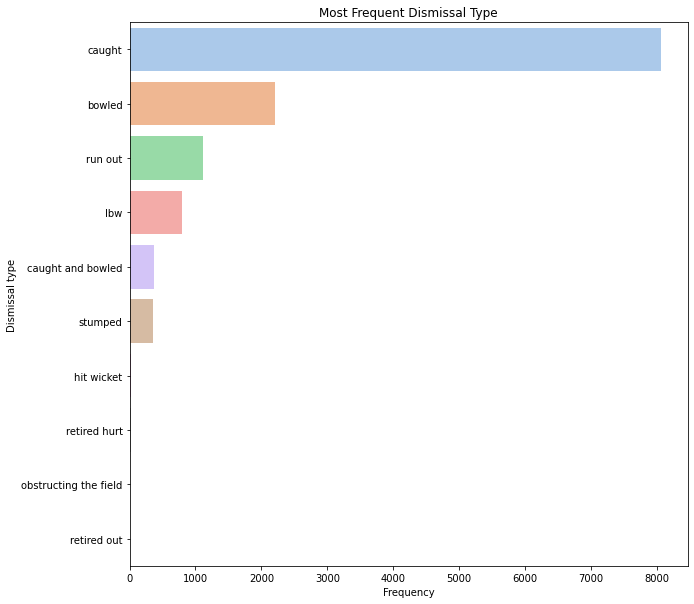

In [0]:
import seaborn as sns
dismissal_kind_pd = dismissal_kind.toPandas()

plt.figure(figsize=(10,10))
sns.barplot(x = 'frequency', y = 'dismissal_kind', data = dismissal_kind_pd, palette = 'pastel')
plt.title('Most Frequent Dismissal Type')
plt.xlabel('Frequency')
plt.ylabel('Dismissal type')
plt.show()

In [0]:
toss_win_performance = spark.sql("""
                                 SELECT team1, COUNT(*) AS match_played, SUM(CASE WHEN toss_winner = winner THEN 1 ELSE 0 END) AS wins_after_toss
                                 FROM matches_view
                                 WHERE toss_winner = team1
                                 GROUP BY team1
                                 ORDER BY wins_after_toss DESC
                                 """)

In [0]:
toss_win_performance.show()

+--------------------+------------+---------------+
|               team1|match_played|wins_after_toss|
+--------------------+------------+---------------+
| Chennai Super Kings|          52|             33|
|      Mumbai Indians|          54|             33|
|Kolkata Knight Ri...|          44|             29|
|Royal Challengers...|          47|             26|
|    Rajasthan Royals|          41|             21|
|    Delhi Daredevils|          39|             18|
|     Kings XI Punjab|          34|             15|
| Sunrisers Hyderabad|          33|             13|
|      Delhi Capitals|          12|              7|
|     Deccan Chargers|          22|              6|
|Lucknow Super Giants|           6|              4|
|Rising Pune Super...|           5|              4|
|      Gujarat Titans|           6|              3|
|       Gujarat Lions|           7|              3|
|Kochi Tuskers Kerala|           4|              2|
|       Pune Warriors|          10|              2|
|Royal Chall

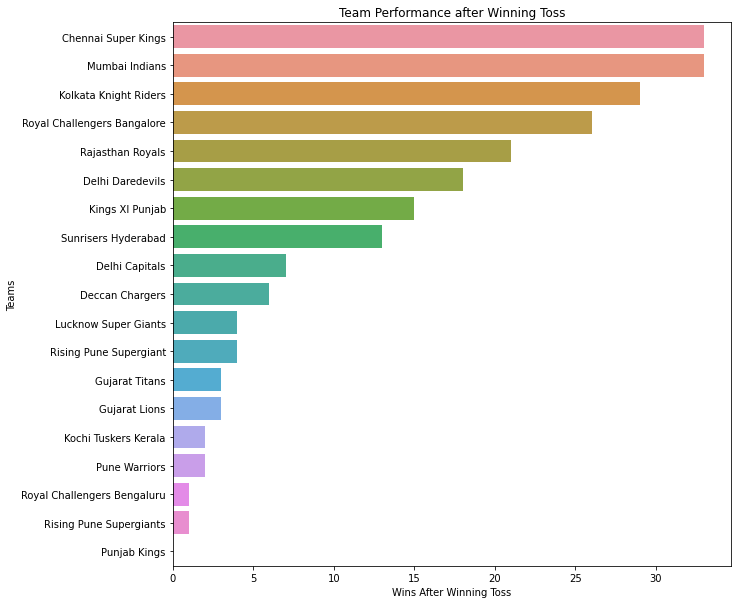

In [0]:
toss_win_performance_pd = toss_win_performance.toPandas()

plt.figure(figsize=(10,10))
sns.barplot(x = 'wins_after_toss', y = 'team1', data = toss_win_performance_pd)
plt.title('Team Performance after Winning Toss')
plt.xlabel('Wins After Winning Toss')
plt.ylabel('Teams')
plt.show()

In [0]:
deliveries.select("is_wicket").distinct().count()

Out[167]: 2

In [0]:
most_wickets = spark.sql("""
                         SELECT m.venue, COUNT(CASE WHEN d.is_wicket = true THEN 1 ELSE 0 END) AS total_wickets
                         FROM deliveries_view d
                         JOIN matches_view m ON d.match_id = m.id
                         GROUP BY m.venue
                         ORDER BY total_wickets DESC 
                         """)

In [0]:
most_wickets.show()

+--------------------+-------------+
|               venue|total_wickets|
+--------------------+-------------+
|        Eden Gardens|        17988|
|    Wankhede Stadium|        17591|
|M Chinnaswamy Sta...|        14907|
|    Feroz Shah Kotla|        13950|
|MA Chidambaram St...|        11760|
|Rajiv Gandhi Inte...|        11604|
|Dubai Internation...|        11229|
|Sawai Mansingh St...|        11150|
|Wankhede Stadium,...|        10915|
|Punjab Cricket As...|         8266|
|Sheikh Zayed Stadium|         6925|
|MA Chidambaram St...|         6816|
|Sharjah Cricket S...|         6672|
|Narendra Modi Sta...|         5660|
|Maharashtra Crick...|         5294|
|Dr DY Patil Sport...|         4905|
|Brabourne Stadium...|         4057|
|Dr DY Patil Sport...|         3993|
|Arun Jaitley Stad...|         3963|
|Eden Gardens, Kol...|         3858|
+--------------------+-------------+
only showing top 20 rows



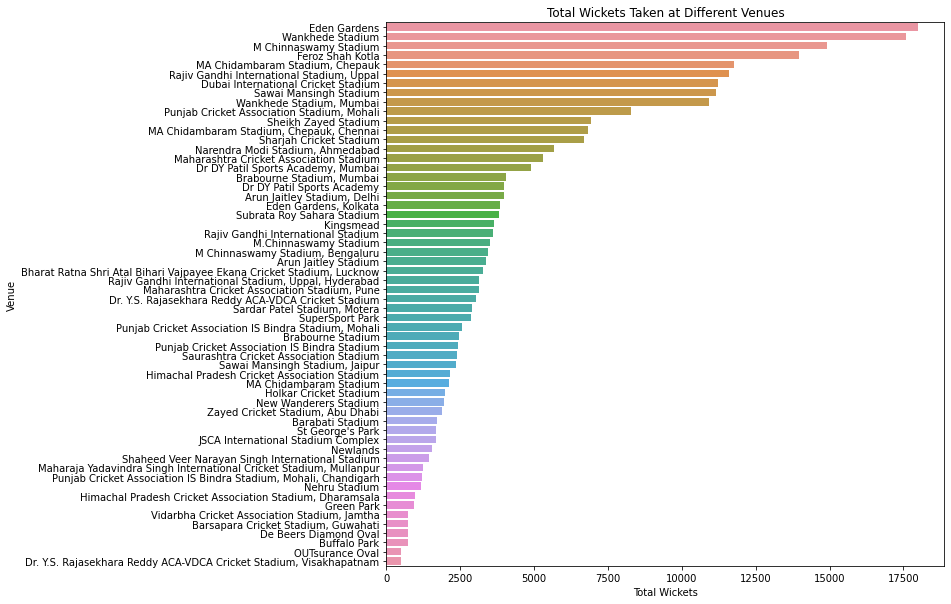

In [0]:
most_wickets_pd = most_wickets.toPandas()

plt.figure(figsize=(10,10))
sns.barplot(x = 'total_wickets', y = 'venue', data = most_wickets_pd)
plt.title('Total Wickets Taken at Different Venues')
plt.xlabel('Total Wickets')
plt.ylabel('Venue')
plt.show()

In [0]:
most_runs = spark.sql("""
                      SELECT m.venue, SUM(d.total_runs) AS total_runs
                      FROM matches_view m
                      JOIN deliveries_view d ON d.match_id = m.id
                      GROUP BY m.venue
                      ORDER BY total_runs DESC
                      """)

In [0]:
most_runs.show()

+--------------------+----------+
|               venue|total_runs|
+--------------------+----------+
|        Eden Gardens|     23658|
|    Wankhede Stadium|     23407|
|M Chinnaswamy Sta...|     20263|
|    Feroz Shah Kotla|     18421|
|Wankhede Stadium,...|     15587|
|MA Chidambaram St...|     15277|
|Rajiv Gandhi Inte...|     14888|
|Dubai Internation...|     14450|
|Sawai Mansingh St...|     14264|
|Punjab Cricket As...|     10987|
|MA Chidambaram St...|      8866|
|Sheikh Zayed Stadium|      8857|
|Sharjah Cricket S...|      8583|
|Narendra Modi Sta...|      8150|
|Maharashtra Crick...|      7007|
|Dr DY Patil Sport...|      6573|
|Arun Jaitley Stad...|      6091|
|Eden Gardens, Kol...|      6085|
|Brabourne Stadium...|      5824|
|M Chinnaswamy Sta...|      5322|
+--------------------+----------+
only showing top 20 rows



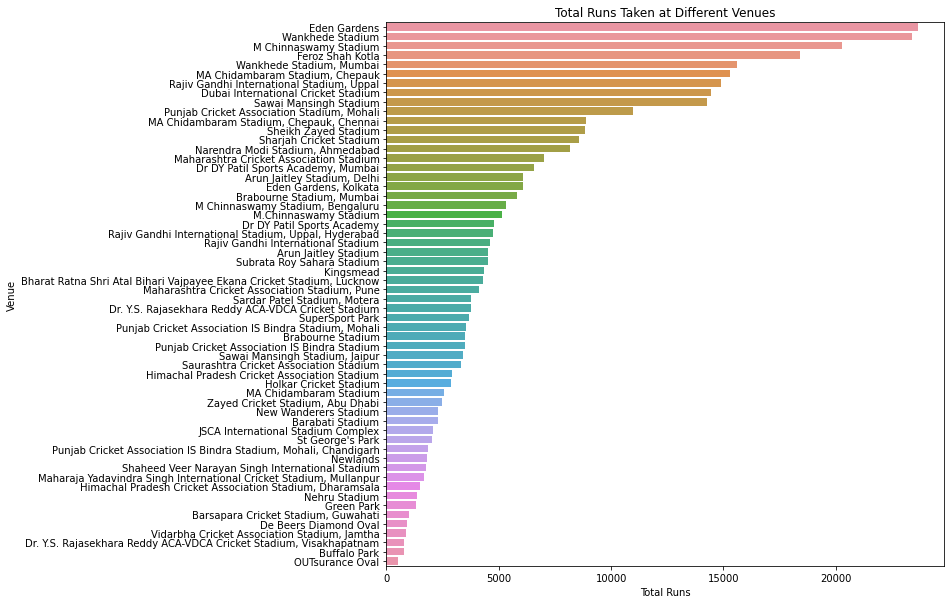

In [0]:
most_runs_pd = most_runs.toPandas()

plt.figure(figsize=(10,10))
sns.barplot(x = 'total_runs', y = 'venue', data = most_runs_pd)
plt.title('Total Runs Taken at Different Venues')
plt.xlabel('Total Runs')
plt.ylabel('Venue')
plt.show()

In [0]:
players = spark.sql("""
                    SELECT batter, SUM(total_runs) AS max_runs
                    FROM deliveries_view
                    GROUP BY batter
                    ORDER BY max_runs DESC
                    LIMIT 20
                    """)

In [0]:
players.show()

+--------------+--------+
|        batter|max_runs|
+--------------+--------+
|       V Kohli|    8307|
|      S Dhawan|    7119|
|     DA Warner|    6910|
|     RG Sharma|    6884|
|      SK Raina|    5780|
|      MS Dhoni|    5505|
|AB de Villiers|    5354|
|      CH Gayle|    5336|
|    RV Uthappa|    5246|
|    KD Karthik|    5066|
|      KL Rahul|    4887|
|     AM Rahane|    4850|
|  F du Plessis|    4741|
|     SV Samson|    4587|
|     AT Rayudu|    4515|
|     G Gambhir|    4479|
|     SR Watson|    4042|
|     MK Pandey|    4039|
|    JC Buttler|    3773|
|      SA Yadav|    3704|
+--------------+--------+



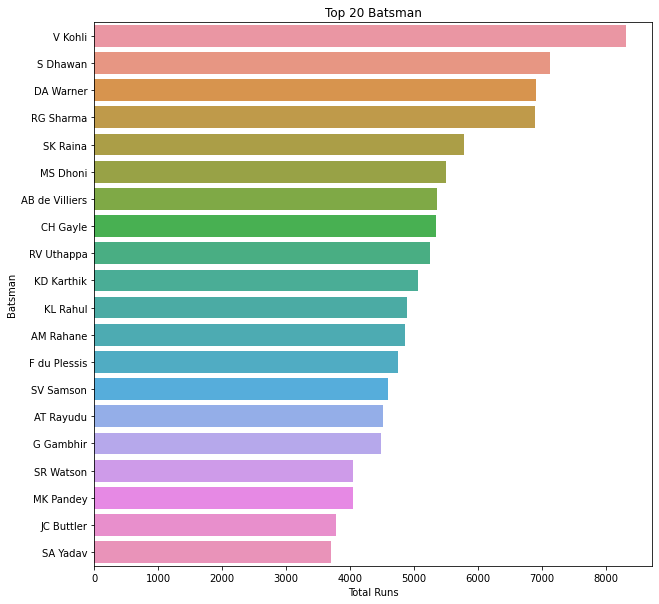

In [0]:
players_pd = players.toPandas()

plt.figure(figsize=(10,10))
sns.barplot(x = 'max_runs', y = 'batter', data = players_pd)
plt.title('Top 20 Batsman')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.show()